# Quantum bounds through the NPA hierarchy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ncpol2sdpa as ncp
from ncpol2sdpa import *
from scipy.optimize import minimize_scalar
from joblib import Parallel, delayed
import json

## Debugging

This time, we want to implement the NPA hierarchy with unitaries: consider measurement operatos $A_x$, $B_y$ such that

$$A_x^2 = \mathbb{I}, \qquad B_y^2 = \mathbb{I}.$$

In [25]:
# Define quantum operators
A_config = [2,2]
B_config = [2,2]

# Operators in problem
A = [Ai for Ai in ncp.generate_measurements(A_config, 'A')]
B = [Bj for Bj in ncp.generate_measurements(B_config, 'B')]

ops = ncp.flatten([A,B])        # Base monomials involved in problem
subs = {}

# 1. Unitarity: A^2 = 1
for op in ops:
    subs[op**2] = 1

# 2. Commutation: force a canonical ordering B*A → A*B
for Ai in ncp.flatten(A):
    for Bj in ncp.flatten(B):
        subs[Bj * Ai] = Ai * Bj

Let us verfy that for the interpreter, $A_0$ and $A_1$ do not commute:

In [40]:
A0 = A[0][0]
A1 = A[1][0]
B0 = B[0][0]
B1 = B[1][0]

print(A0 * A1 == A1 * A0)  # This should print: False
print(B0 * B1 == B1 * B0)  # This should print: False

False
False


and the same for $B_0$ and $B_1$. Let us also verify if $[A_x, B_y] = 0$: 

In [42]:
print(A0 * B0 == B0 * A0)  # This should print: False
print(A0 * B1 == B1 * A0)

False
False


Hence, we should impose $[A_x, B_y] = 0$ in our substitutions. Finally, let us verify that measurement operators are Hermitian:

In [43]:
from sympy.physics.quantum.operator import HermitianOperator

for i, row in enumerate(A):
    for j, op in enumerate(row):
        print(f"A[{i}][{j}] is Hermitian? {isinstance(op, HermitianOperator)}")
for i, row in enumerate(B):
    for j, op in enumerate(row):
        print(f"B[{i}][{j}] is Hermitian? {isinstance(op, HermitianOperator)}")

A[0][0] is Hermitian? True
A[1][0] is Hermitian? True
B[0][0] is Hermitian? True
B[1][0] is Hermitian? True


We finally print our substitutions:

In [26]:
subs

{A0**2: 1,
 A1**2: 1,
 B0**2: 1,
 B1**2: 1,
 B0*A0: A0*B0,
 B1*A0: A0*B1,
 B0*A1: A1*B0,
 B1*A1: A1*B1}

## Level 1

In [29]:
moment_ineqs = []                      # moment inequalities
moment_eqs = []                        # moment equalities
op_eqs = []     # operator equalities
op_ineqs = []                          # operator inequalities
extra_monos = []   # extra monomials

# Compute quantum value of Bell expression at (p1, p4) for a given Theta
def compute_beta(p1, p4, Theta):
    s = np.sqrt(2)
    tan_2T = np.tan(2 * Theta)
    sin_2T = np.sin(2 * Theta)
    cos_2T = np.cos(2 * Theta)
    cos_4T = np.cos(4 * Theta)
    sin_4T = np.sin(4 * Theta)

    beta_expr = 1/16 * (
        4 * (s * (B[0][0] + B[1][0]) / (tan_2T * sin_2T) + 4 * p1 * A[0][0] + 8 * p4 * A[1][0]) +
        (4 / s) / (sin_2T ** 2) * (
            (B[0][0] + B[1][0]) * (-3 + cos_4T) * p1
            - 2 * A[0][0] * B[0][0] * (cos_4T - p1 * cos_2T)
            - 2 * A[0][0] * B[1][0] * (cos_4T - p1 * cos_2T)
            + 2 * sin_2T * (
                4 * (-B[0][0] + B[1][0]) * p4 * sin_2T ** 2
                + A[1][0] * B[1][0] * (-1 + cos_2T * p1 - 2 * p4 * sin_4T)
                - A[1][0] * B[0][0] * (-1 + cos_2T * p1 + 2 * p4 * sin_4T)
            )
        )
    )

    sdp = ncp.SdpRelaxation(ops, verbose=0, normalized=True, parallel=0)
    sdp.get_relaxation(
        level=1,
        equalities = op_eqs[:],
        inequalities = op_ineqs[:],
        momentequalities = moment_eqs[:],
        momentinequalities = moment_ineqs[:],
        objective=-beta_expr,
        substitutions=subs,
        extramonomials = extra_monos
    )
    sdp.solve(solver="mosek")
    return -sdp.dual

# Minimize r for fixed φ and Theta
def minimize_r(phi, Theta):
    def objective(r):
        if r < 0:
            return np.inf
        p1 = r * np.cos(phi)
        p4 = r * np.sin(phi)
        beta = compute_beta(p1, p4, Theta)
        return r if beta >= 1.00001 else np.inf

    res = minimize_scalar(objective, bounds=(0, 1), method='bounded')
    if res.success and np.isfinite(res.fun):
        r = res.x
        return r * np.cos(phi), r * np.sin(phi)
    else:
        return None

# Main routine
def compute_boundary(Theta, num_points=200, n_jobs=-1):
    phis = np.linspace(0, np.pi, num_points)
    boundary = Parallel(n_jobs=n_jobs)(
        delayed(minimize_r)(phi, Theta) for phi in phis
    )
    boundary = [pt for pt in boundary if pt is not None]
    return np.array(boundary)

### Level 1, $\theta = \pi/4$

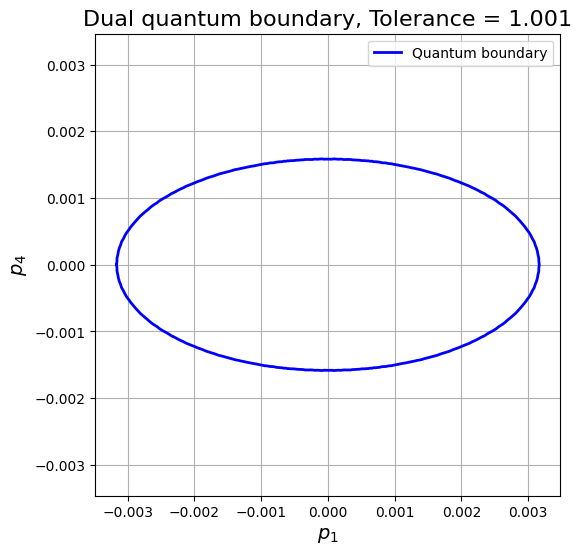

In [30]:
Theta_val = np.pi/4
boundary = compute_boundary(Theta_val)

# Reflect the boundary across the p4-axis
reflected = boundary[boundary[:, 1] != 0] * np.array([1, -1])
full_boundary = np.vstack([boundary, reflected])

# Sort the points by polar angle to ensure a smooth curve
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")
plt.xlabel(r"$p_1$", fontsize=14)
plt.ylabel(r"$p_4$", fontsize=14)
plt.title("Dual quantum boundary, Tolerance = 1.001", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

## Mixed level 1

In [31]:
def get_extra_monomials():
    """
    Returns additional monomials to add to sdp relaxation.
    """

    monos = []

    Aflat = ncp.flatten(A)
    Bflat = ncp.flatten(B)

    #AB
    for a in Aflat:
        for b in Bflat:
            monos += [a*b]
    
    
    return monos[:]

moment_ineqs = []                      # moment inequalities
moment_eqs = []                        # moment equalities
op_eqs = []     # operator equalities
op_ineqs = []                          # operator inequalities
extra_monos = get_extra_monomials()  # extra monomials

# Compute quantum value of Bell expression at (p1, p4) for a given Theta
def compute_beta(p1, p4, Theta):
    s = np.sqrt(2)
    tan_2T = np.tan(2 * Theta)
    sin_2T = np.sin(2 * Theta)
    cos_2T = np.cos(2 * Theta)
    cos_4T = np.cos(4 * Theta)
    sin_4T = np.sin(4 * Theta)

    beta_expr = 1/16 * (
        4 * (s * (B[0][0] + B[1][0]) / (tan_2T * sin_2T) + 4 * p1 * A[0][0] + 8 * p4 * A[1][0]) +
        (4 / s) / (sin_2T ** 2) * (
            (B[0][0] + B[1][0]) * (-3 + cos_4T) * p1
            - 2 * A[0][0] * B[0][0] * (cos_4T - p1 * cos_2T)
            - 2 * A[0][0] * B[1][0] * (cos_4T - p1 * cos_2T)
            + 2 * sin_2T * (
                4 * (-B[0][0] + B[1][0]) * p4 * sin_2T ** 2
                + A[1][0] * B[1][0] * (-1 + cos_2T * p1 - 2 * p4 * sin_4T)
                - A[1][0] * B[0][0] * (-1 + cos_2T * p1 + 2 * p4 * sin_4T)
            )
        )
    )

    sdp = ncp.SdpRelaxation(ops, verbose=0, normalized=True, parallel=0)
    sdp.get_relaxation(
        level=1,
        equalities = op_eqs[:],
        inequalities = op_ineqs[:],
        momentequalities = moment_eqs[:],
        momentinequalities = moment_ineqs[:],
        objective=-beta_expr,
        substitutions=subs,
        extramonomials = extra_monos
    )
    sdp.solve(solver="mosek")
    return -sdp.dual

# Minimize r for fixed φ and Theta
def minimize_r(phi, Theta):
    def objective(r):
        if r < 0:
            return np.inf
        p1 = r * np.cos(phi)
        p4 = r * np.sin(phi)
        beta = compute_beta(p1, p4, Theta)
        return r if beta >= 1.00001 else np.inf

    res = minimize_scalar(objective, bounds=(0, 1), method='bounded')
    if res.success and np.isfinite(res.fun):
        r = res.x
        return r * np.cos(phi), r * np.sin(phi)
    else:
        return None

# Main routine
def compute_boundary(Theta, num_points=200, n_jobs=-1):
    phis = np.linspace(0, np.pi, num_points)
    boundary = Parallel(n_jobs=n_jobs)(
        delayed(minimize_r)(phi, Theta) for phi in phis
    )
    boundary = [pt for pt in boundary if pt is not None]
    return np.array(boundary)

### Mixed level 1, $\theta = \pi/4$

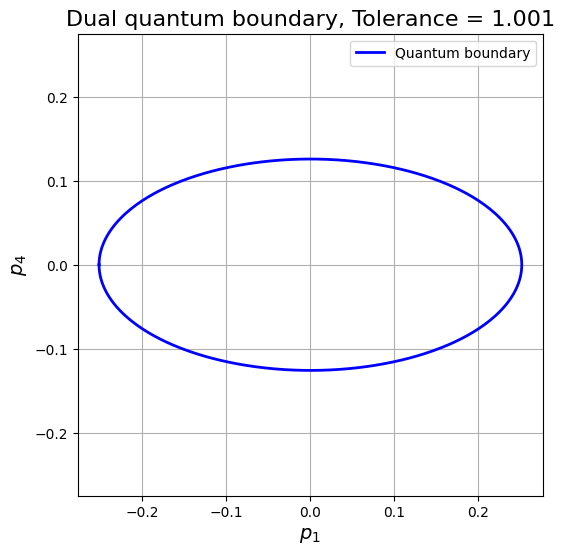

In [32]:
Theta_val = np.pi/4
boundary = compute_boundary(Theta_val)

# Reflect the boundary across the p4-axis
reflected = boundary[boundary[:, 1] != 0] * np.array([1, -1])
full_boundary = np.vstack([boundary, reflected])

# Sort the points by polar angle to ensure a smooth curve
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")
plt.xlabel(r"$p_1$", fontsize=14)
plt.ylabel(r"$p_4$", fontsize=14)
plt.title("Dual quantum boundary, Tolerance = 1.001", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

## Level 2

In [33]:
moment_ineqs = []                      # moment inequalities
moment_eqs = []                        # moment equalities
op_eqs = []     # operator equalities
op_ineqs = []                          # operator inequalities
extra_monos = []   # extra monomials


# Compute quantum value of Bell expression at (p1, p4) for a given Theta
def compute_beta(p1, p4, Theta):
    s = np.sqrt(2)
    tan_2T = np.tan(2 * Theta)
    sin_2T = np.sin(2 * Theta)
    cos_2T = np.cos(2 * Theta)
    cos_4T = np.cos(4 * Theta)
    sin_4T = np.sin(4 * Theta)

    beta_expr = 1/16 * (
        4 * (s * (B[0][0] + B[1][0]) / (tan_2T * sin_2T) + 4 * p1 * A[0][0] + 8 * p4 * A[1][0]) +
        (4 / s) / (sin_2T ** 2) * (
            (B[0][0] + B[1][0]) * (-3 + cos_4T) * p1
            - 2 * A[0][0] * B[0][0] * (cos_4T - p1 * cos_2T)
            - 2 * A[0][0] * B[1][0] * (cos_4T - p1 * cos_2T)
            + 2 * sin_2T * (
                4 * (-B[0][0] + B[1][0]) * p4 * sin_2T ** 2
                + A[1][0] * B[1][0] * (-1 + cos_2T * p1 - 2 * p4 * sin_4T)
                - A[1][0] * B[0][0] * (-1 + cos_2T * p1 + 2 * p4 * sin_4T)
            )
        )
    )

    sdp = ncp.SdpRelaxation(ops, verbose=0, normalized=True, parallel=0)
    sdp.get_relaxation(
        level=2,
        equalities = op_eqs[:],
        inequalities = op_ineqs[:],
        momentequalities = moment_eqs[:],
        momentinequalities = moment_ineqs[:],
        objective=-beta_expr,
        substitutions=subs,
        extramonomials = extra_monos
    )
    sdp.solve(solver="mosek")
    return -sdp.dual

# Minimize r for fixed φ and Theta
def minimize_r(phi, Theta):
    def objective(r):
        if r < 0:
            return np.inf
        p1 = r * np.cos(phi)
        p4 = r * np.sin(phi)
        beta = compute_beta(p1, p4, Theta)
        return r if beta >= 1.00001 else np.inf

    res = minimize_scalar(objective, bounds=(0, 1), method='bounded')
    if res.success and np.isfinite(res.fun):
        r = res.x
        return r * np.cos(phi), r * np.sin(phi)
    else:
        return None

# Main routine
def compute_boundary(Theta, num_points=200, n_jobs=-1):
    phis = np.linspace(0, np.pi, num_points)
    boundary = Parallel(n_jobs=n_jobs)(
        delayed(minimize_r)(phi, Theta) for phi in phis
    )
    boundary = [pt for pt in boundary if pt is not None]
    return np.array(boundary)

### Level 2, $\theta = \pi/4$

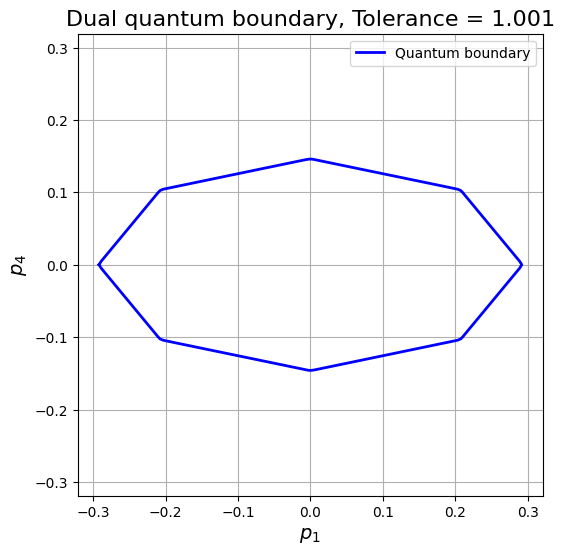

In [34]:
Theta_val = np.pi/4
boundary = compute_boundary(Theta_val)

# Reflect the boundary across the p4-axis
reflected = boundary[boundary[:, 1] != 0] * np.array([1, -1])
full_boundary = np.vstack([boundary, reflected])

# Sort the points by polar angle to ensure a smooth curve
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")
plt.xlabel(r"$p_1$", fontsize=14)
plt.ylabel(r"$p_4$", fontsize=14)
plt.title("Dual quantum boundary, Tolerance = 1.001", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

### Level 2, $\theta = \pi/8 + \pi/64$

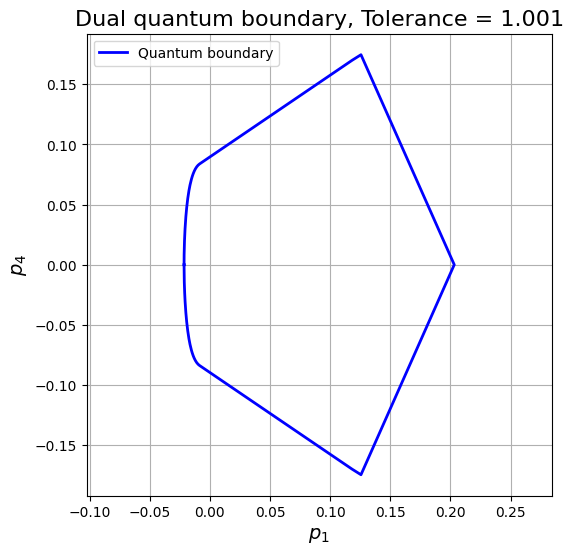

In [35]:
Theta_val = np.pi/8 + np.pi/(64)
boundary = compute_boundary(Theta_val)

# Reflect the boundary across the p4-axis
reflected = boundary[boundary[:, 1] != 0] * np.array([1, -1])
full_boundary = np.vstack([boundary, reflected])

# Sort the points by polar angle to ensure a smooth curve
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")
plt.xlabel(r"$p_1$", fontsize=14)
plt.ylabel(r"$p_4$", fontsize=14)
plt.title("Dual quantum boundary, Tolerance = 1.001", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

### Level 2, $\theta = \pi/4 - \pi/64$

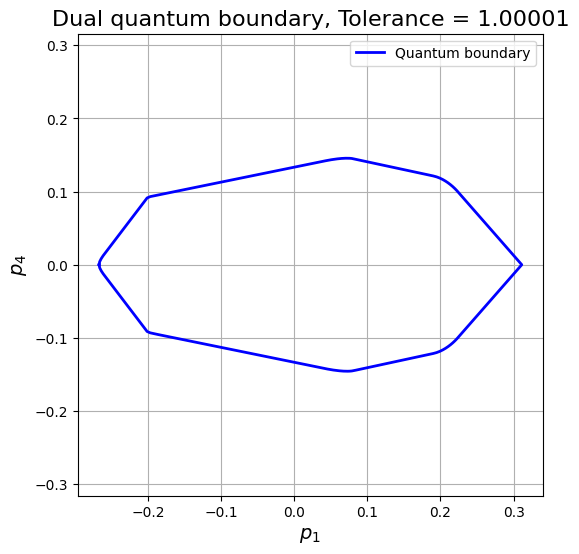

In [36]:
Theta_val = np.pi / 4 - np.pi/(64)
boundary = compute_boundary(Theta_val)

# Reflect the boundary across the p4-axis
reflected = boundary[boundary[:, 1] != 0] * np.array([1, -1])
full_boundary = np.vstack([boundary, reflected])

# Sort the points by polar angle to ensure a smooth curve
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")
plt.xlabel(r"$p_1$", fontsize=14)
plt.ylabel(r"$p_4$", fontsize=14)
plt.title("Dual quantum boundary, Tolerance = 1.00001", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

## Mixed level 2

In [37]:
def get_extra_monomials():
    """
    Returns additional monomials to add to sdp relaxation.
    """

    monos = []

    Aflat = ncp.flatten(A)
    Bflat = ncp.flatten(B)

    # ABB
    for a in Aflat:
        for b in Bflat:
            for b2 in Bflat:
                monos += [a*b*b2]
    
    return monos[:]

moment_ineqs = []                      # moment inequalities
moment_eqs = []                        # moment equalities
op_eqs = []     # operator equalities
op_ineqs = []                          # operator inequalities
extra_monos = get_extra_monomials()  # extra monomials

# Compute quantum value of Bell expression at (p1, p4) for a given Theta
def compute_beta(p1, p4, Theta):
    s = np.sqrt(2)
    tan_2T = np.tan(2 * Theta)
    sin_2T = np.sin(2 * Theta)
    cos_2T = np.cos(2 * Theta)
    cos_4T = np.cos(4 * Theta)
    sin_4T = np.sin(4 * Theta)

    beta_expr = 1/16 * (
        4 * (s * (B[0][0] + B[1][0]) / (tan_2T * sin_2T) + 4 * p1 * A[0][0] + 8 * p4 * A[1][0]) +
        (4 / s) / (sin_2T ** 2) * (
            (B[0][0] + B[1][0]) * (-3 + cos_4T) * p1
            - 2 * A[0][0] * B[0][0] * (cos_4T - p1 * cos_2T)
            - 2 * A[0][0] * B[1][0] * (cos_4T - p1 * cos_2T)
            + 2 * sin_2T * (
                4 * (-B[0][0] + B[1][0]) * p4 * sin_2T ** 2
                + A[1][0] * B[1][0] * (-1 + cos_2T * p1 - 2 * p4 * sin_4T)
                - A[1][0] * B[0][0] * (-1 + cos_2T * p1 + 2 * p4 * sin_4T)
            )
        )
    )

    sdp = ncp.SdpRelaxation(ops, verbose=0, normalized=True, parallel=0)
    sdp.get_relaxation(
        level=2,
        equalities = op_eqs[:],
        inequalities = op_ineqs[:],
        momentequalities = moment_eqs[:],
        momentinequalities = moment_ineqs[:],
        objective=-beta_expr,
        substitutions=subs,
        extramonomials = extra_monos
    )
    sdp.solve(solver="mosek")
    return -sdp.dual

# Minimize r for fixed φ and Theta
def minimize_r(phi, Theta):
    def objective(r):
        if r < 0:
            return np.inf
        p1 = r * np.cos(phi)
        p4 = r * np.sin(phi)
        beta = compute_beta(p1, p4, Theta)
        return r if beta >= 1.00001 else np.inf

    res = minimize_scalar(objective, bounds=(0, 1), method='bounded')
    if res.success and np.isfinite(res.fun):
        r = res.x
        return r * np.cos(phi), r * np.sin(phi)
    else:
        return None

# Main routine
def compute_boundary(Theta, num_points=200, n_jobs=-1):
    phis = np.linspace(0, np.pi, num_points)
    boundary = Parallel(n_jobs=n_jobs)(
        delayed(minimize_r)(phi, Theta) for phi in phis
    )
    boundary = [pt for pt in boundary if pt is not None]
    return np.array(boundary)

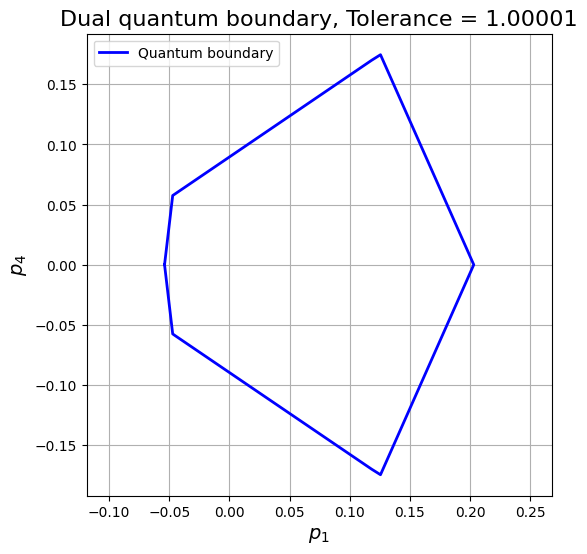

In [39]:
Theta_val = np.pi / 8 + np.pi/(64)
boundary = compute_boundary(Theta_val)

# Reflect the boundary across the p4-axis
reflected = boundary[boundary[:, 1] != 0] * np.array([1, -1])
full_boundary = np.vstack([boundary, reflected])

# Sort the points by polar angle to ensure a smooth curve
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")
plt.xlabel(r"$p_1$", fontsize=14)
plt.ylabel(r"$p_4$", fontsize=14)
plt.title("Dual quantum boundary, Tolerance = 1.00001", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

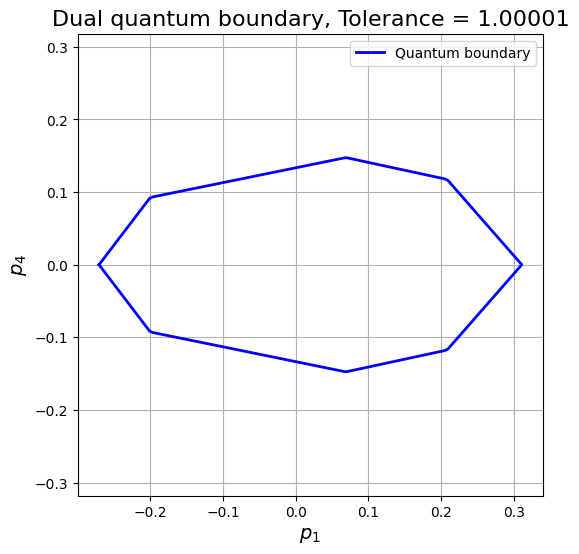

In [38]:
Theta_val = np.pi / 4 - np.pi/(64)
boundary = compute_boundary(Theta_val)

# Reflect the boundary across the p4-axis
reflected = boundary[boundary[:, 1] != 0] * np.array([1, -1])
full_boundary = np.vstack([boundary, reflected])

# Sort the points by polar angle to ensure a smooth curve
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")
plt.xlabel(r"$p_1$", fontsize=14)
plt.ylabel(r"$p_4$", fontsize=14)
plt.title("Dual quantum boundary, Tolerance = 1.00001", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()